# Lithium prescribing trends in England. 

## **Background and Rationale**
For over 60 years lithium has been the gold standard for the treatment and prevention of relapse in bipolar disorder.  In recent years, published literature has confirmed the superiority of lithium in this field, including two meta-analysis of RCTs (Severus et al. 2014, Miura et al. 2014) and one of observational studies (Kessing et al 2018).  Yet in various countries, authors have described a decline in lithium use (Karanti et al. 2016), including in the UK (Hayes et al. 2011, Lyall et al. 2019) 

We wish to describe long term lithium prescribing trends in England.  Previous authors have reported regional variations in lithium use across the country (POMH Lithium report, 2008). We would like to explore these national variations in use, to further understand trends in lithium prescribing in the UK. 

## **Proposed project**
### Title:  
Lithium prescribing trends
### Description:  
* Total number of items of lithium dispensed each year from 1998 to 2018
* Total number of lithium items per 1000 patient population for each CCG
* Total number of hospital prescriptions for lithium dispensed at sample timepoints
* Total number of lithium patients registered in GPs as determined by QOF data
* Total number of DDDs of lithium dispensed each year from 2010 to 2019 



In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

### Print graph of lithium use from 1998 to 2018 using PCA data

In [2]:
sql = """
SELECT
drug_name,
Chemical_code_current,
year,
items

FROM ebmdatalab.helen.trends_from_pca_final_2018new

WHERE (Chemical_code_current = "0402030K0" OR Chemical_code_current = "0402030P0")

GROUP BY
year,
drug_name,
Chemical_code_current,
items

ORDER BY
year


"""

df_lithium_pca = bq.cached_read(sql, csv_path = 'lithium_pca.csv')

In [3]:
df_lithium_pca.head()

,drug_name,Chemical_code_current,year,items
0,Lithium Carb_Tab Slow 400mg,0402030K0,1998,100.0
1,Camcolit 250_Tab 250mg,0402030K0,1998,42300.0
2,Camcolit 400_Tab 400mg,0402030K0,1998,32600.0
3,Liskonum_Tab 450mg,0402030K0,1998,7800.0
4,Priadel_Tab 400mg,0402030K0,1998,396700.0


In [4]:
df_lithium_pca_totalcount = df_lithium_pca.groupby(['year'], as_index=False).sum()
df_lithium_pca_totalcount.head(20)

,year,items
0,1998,677500.0
1,1999,694500.0
2,2000,714495.0
3,2001,738647.0
4,2002,752838.0
5,2003,765062.0
6,2004,780240.0
7,2005,786166.0
8,2006,793642.0
9,2007,810086.0


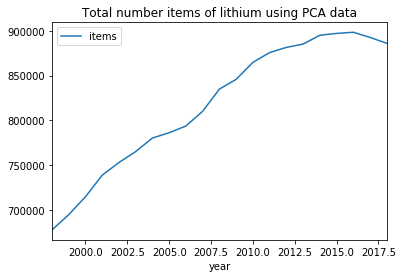

In [5]:
plot1 = df_lithium_pca.groupby("year").sum().plot(kind='line', title="Total number items of lithium using PCA data")

## Describe total lithium dispensed using monthly practice level data from 2010 to 2019

In [6]:
sql2 = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
rx.practice,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "0402030K0%", items,0)) AS carbonate,
sum(IF(rx.bnf_code LIKE "0402030P0%", items,0)) AS citrate,
sum(items) AS total_lithium,
sum(actual_cost) AS total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practices AS prac
ON
rx.practice = prac.code 
JOIN
  hscic.ccgs AS ccgs
ON
rx.pct=ccgs.code
WHERE
  prac.setting = 4
  AND (bnf_code LIKE "0402030K0%" OR ##carbonate
  bnf_code LIKE "0402030P0%") ##citrate
  AND
ccgs.org_type='CCG'
GROUP BY
rx.month,
rx.practice,
rx.pct,
chemical_code,
chemical
ORDER BY
month"""

df_lithium = bq.cached_read(sql2, csv_path='lithium.csv')

In [7]:
df_lithium['month'] = df_lithium['month'].astype('datetime64[ns]')
df_lithium.head()

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,H81019,09Y,0402030K0,Lithium Carbonate,7,0,7,27.23
1,2010-08-01,G81029,09F,0402030K0,Lithium Carbonate,25,0,25,46.04
2,2010-08-01,B81077,03H,0402030K0,Lithium Carbonate,5,0,5,7.97
3,2010-08-01,F85063,08D,0402030K0,Lithium Carbonate,12,0,12,40.90
4,2010-08-01,H85053,08T,0402030K0,Lithium Carbonate,8,0,8,2.73


In [8]:
df_lithium["chemical"].unique()#shows me the unique values within the chemical column

array(['Lithium Carbonate', 'Lithium Citrate'], dtype=object)

In [9]:
df_lithium.nunique()#counts the number of unique items in each column.  

month               110
practice           8022
pct                 191
chemical_code         2
chemical              2
carbonate           136
citrate              35
total_lithium       135
total_cost       190699
dtype: int64

In [10]:
df_carbonate = df_lithium.loc[df_lithium["chemical"] == "Lithium Carbonate"]
df_carbonate.head()#shows me the data for Lithium Carbonate

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,H81019,09Y,0402030K0,Lithium Carbonate,7,0,7,27.23
1,2010-08-01,G81029,09F,0402030K0,Lithium Carbonate,25,0,25,46.04
2,2010-08-01,B81077,03H,0402030K0,Lithium Carbonate,5,0,5,7.97
3,2010-08-01,F85063,08D,0402030K0,Lithium Carbonate,12,0,12,40.90
4,2010-08-01,H85053,08T,0402030K0,Lithium Carbonate,8,0,8,2.73


In [11]:
df_citrate = df_lithium.loc[df_lithium["chemical"] == "Lithium Citrate"]
df_citrate.head()#shows me the data for Lithium Citrate

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
79,2010-08-01,C84605,04N,0402030P0,Lithium Citrate,0,1,1,5.36
90,2010-08-01,P81103,01E,0402030P0,Lithium Citrate,0,2,2,26.39
100,2010-08-01,G83001,08A,0402030P0,Lithium Citrate,0,1,1,42.66
111,2010-08-01,C88079,03N,0402030P0,Lithium Citrate,0,1,1,10.36
127,2010-08-01,N81046,02F,0402030P0,Lithium Citrate,0,2,2,44.80


In [12]:
ccg_lithium_totalcount = df_lithium.groupby(["month", "pct"], as_index=False).sum()
ccg_lithium_totalcount.tail()#shows me the data grouped by PCT, therefore representing CCGs

,month,pct,carbonate,citrate,total_lithium,total_cost
21005,2019-09-01,99H,364,2,366,1083.79398
21006,2019-09-01,99J,600,3,603,1216.91034
21007,2019-09-01,99K,221,5,226,530.90471
21008,2019-09-01,99M,234,1,235,783.96083
21009,2019-09-01,99N,668,8,676,1346.09597


In [13]:
ccg_lithium_totalcount.describe()

,carbonate,citrate,total_lithium,total_cost
count,21010.000000,21010.000000,21010.000000,21010.000000
mean,375.297668,3.816564,379.114231,691.242443
std,300.596623,4.707237,304.017283,600.048727
min,27.000000,0.000000,27.000000,49.340000
25%,201.000000,1.000000,203.000000,337.285000
50%,290.000000,2.000000,293.000000,509.399650
75%,446.000000,5.000000,450.000000,822.431118
max,2147.000000,54.000000,2167.000000,5321.818920


### Display total no. of items dispensed per year

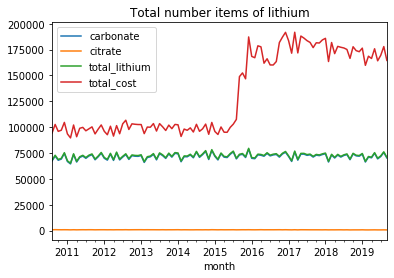

In [14]:
plot2 = df_lithium.groupby("month").sum().plot(kind='line', title="Total number items of lithium")

(40000, 100000)

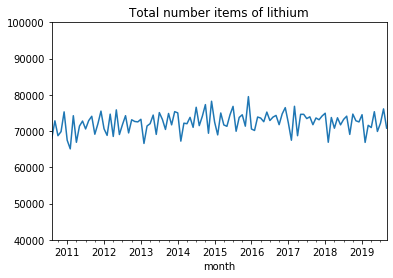

In [15]:
plot3 = df_lithium.groupby("month")['total_lithium'].sum().plot(kind='line', title="Total number items of lithium")
plt.ylim(40000, 100000)

In [16]:
#add in timelines to show publication of NICE 2014 guidance.
#df_nice = 
#plt.plot(df_nice['month'], 'r--')
#plt.show()

### Describe no. of lithium items per 1000 patients in each CCG to show Geographical Variation

In [17]:
##get list size info.  Note this will restrict the data to Oct 2014 onwards because of the practice_statistics database which only goes back to Oct 2014.
sql3 = """
SELECT month, 
pct_id AS pct,
AVG(total_list_size) AS list_size
FROM ebmdatalab.hscic.practice_statistics 
group by 
month, pct
order by
month, pct,
list_size
"""
df_list = bq.cached_read(sql3, csv_path='df_list.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(-20)

,month,pct,list_size
0,2014-10-01,NaN,0.000000
1,2014-10-01,00C,7616.000000
2,2014-10-01,00D,5662.509804
3,2014-10-01,00F,6102.176471
4,2014-10-01,00G,8058.750000
...,...,...,...
13373,2019-09-01,11X,8965.030769
13374,2019-09-01,12D,10577.434783
13375,2019-09-01,12F,6763.060000
13376,2019-09-01,13T,8666.229508


In [18]:
ccg_lithium_count = df_lithium.groupby(["month", "pct"])["total_lithium"].sum().reset_index()
ccg_lithium_count.head(-20)

,month,pct,total_lithium
0,2010-08-01,00C,333
1,2010-08-01,00D,496
2,2010-08-01,00J,456
3,2010-08-01,00K,295
4,2010-08-01,00L,595
...,...,...,...
20985,2019-09-01,11N,1007
20986,2019-09-01,11X,619
20987,2019-09-01,12D,224
20988,2019-09-01,12F,750


In [19]:
#merge dataframes to show items per 1000

df_lithium_per1000 = pd.merge(ccg_lithium_totalcount, df_list, on=['month', 'pct'])
df_lithium_per1000['items_per_1000'] = round(1000* (df_lithium_per1000['total_lithium']/df_lithium_per1000['list_size']),0)
df_lithium_per1000.head(-20)

,month,pct,carbonate,citrate,total_lithium,total_cost,list_size,items_per_1000
0,2014-10-01,00C,376,5,381,267.93000,7616.000000,50.0
1,2014-10-01,00D,636,3,639,519.49000,5662.509804,113.0
2,2014-10-01,00J,603,4,607,512.11000,6094.536585,100.0
3,2014-10-01,00K,308,2,310,425.18000,6354.130435,49.0
4,2014-10-01,00L,722,6,728,1425.31000,6852.085106,106.0
...,...,...,...,...,...,...,...,...
11039,2019-09-01,11N,1003,4,1007,2439.90806,9708.200000,104.0
11040,2019-09-01,11X,610,9,619,1328.32173,8965.030769,69.0
11041,2019-09-01,12D,222,2,224,495.64458,10577.434783,21.0
11042,2019-09-01,12F,747,3,750,1283.15980,6763.060000,111.0


In [20]:
df_lithium_per1000['month'] = df_lithium_per1000['month'].astype('datetime64[ns]')

In [21]:
df_lithium_per1000.describe()

,carbonate,citrate,total_lithium,total_cost,list_size,items_per_1000
count,11064.000000,11064.000000,11064.000000,11064.000000,11064.000000,11064.000000
mean,347.860177,3.344089,351.204266,779.409003,7953.832679,45.906905
std,241.358996,4.033228,243.674721,588.525283,1962.515474,32.186258
min,40.000000,0.000000,40.000000,74.530000,3682.023810,3.000000
25%,198.000000,1.000000,200.000000,394.531682,6548.007177,27.000000
50%,282.000000,2.000000,285.000000,624.929300,7733.210884,39.000000
75%,430.000000,4.000000,435.000000,963.607722,9241.958333,56.000000
max,1996.000000,45.000000,2007.000000,4827.678090,16296.600000,316.000000


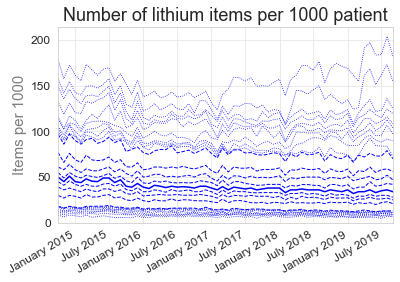

In [22]:
#create sample deciles

charts.deciles_chart(
        df_lithium_per1000,
        period_column='month',
        column='items_per_1000',
        title="Number of lithium items per 1000 patient",
        ylabel='Items per 1000',
        show_outer_percentiles=True,
        show_legend=False,
)

plt.show()

In [24]:
##Restrict to one month to create a map - Sep2019
df_lithium_inSep19 = df_lithium_per1000.loc[(df_lithium_per1000['month'] == '2019-09-01')]
df_lithium_inSep19.head()

,month,pct,carbonate,citrate,total_lithium,total_cost,list_size,items_per_1000
10873,2019-09-01,00C,314,0,314,272.77172,9914.545455,32.0
10874,2019-09-01,00D,535,1,536,619.62149,8385.142857,64.0
10875,2019-09-01,00J,476,1,477,578.62783,8704.500000,55.0
10876,2019-09-01,00K,219,3,222,770.75465,9351.562500,24.0
10877,2019-09-01,00L,681,3,684,3248.08458,8002.780488,85.0


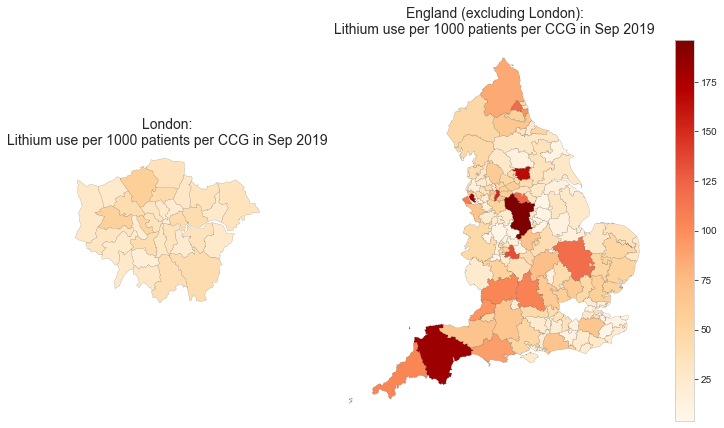

In [25]:
#create choropeth map showing recent prescribing variation (Sep 2019)
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df_lithium_inSep19, title="Lithium use per 1000 patients per CCG in Sep 2019", column='items_per_1000', separate_london=True)
plt.show()

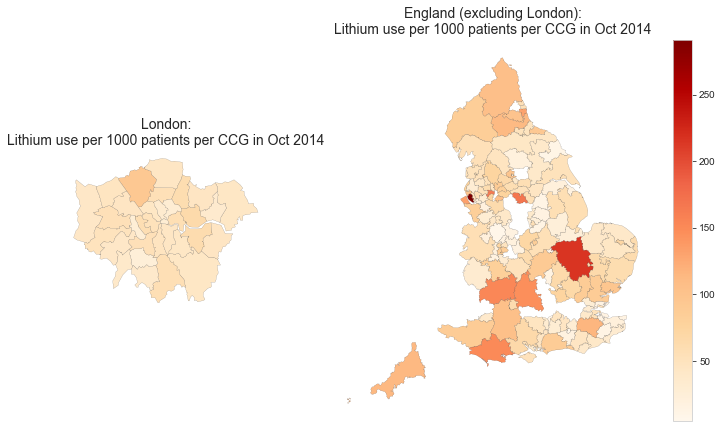

In [26]:
#create choreopath map showing prescribing variation prior to NICE implementation (Oct 2014)
df_lithium_inOct14 = df_lithium_per1000.loc[(df_lithium_per1000['month'] == '2014-10-01')]
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df_lithium_inOct14, title="Lithium use per 1000 patients per CCG in Oct 2014", column='items_per_1000', separate_london=True)
plt.show()

### Describe lithium items prescribed by non-GP facilities in UK to check if bias caused by changes in secondary care prescribing

### Extract data from QOF to show no. of lithium patients per CCG as determined by QOF denominators for lithium measures.

### Compare QOF no of lithium patients with no of lithium items per CCG

### Describe the no of DDDs or average quantity in each lithium item.  Has this changed over time?